# New York City Taxi Fare Prediction | LightGBM Model

## 1. Download the Dataset

In [1]:
#!kaggle competitions download -c new-york-city-taxi-fare-prediction

In [2]:
#import zipfile
#with zipfile.ZipFile('new-york-city-taxi-fare-prediction.zip', 'r') as zip_ref:
#    zip_ref.extractall('taxi-nyc')

In [3]:
!head taxi-nyc/train.csv

key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1
2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.76127,-73.991242,40.750562,2
2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.98713,40.733143,-73.991567,40.758092,1
2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.73163,-73.972892,40.758233,1
2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.9513,40.774138,-73.990095,40.751048,1
2012-12-03 13:10:00.000000125,9,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.99

### Load the Training and Testing Data
* Only import 1% of the train dataset and don't include the key

In [4]:
import pandas as pd
import random
sample_fraction = 0.01
selected_cols = 'fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'.split(',')
dtypes = {
    'fare_amount': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'passenger_count': 'uint8'
}
random.seed(42)
def skip_row(row_index):
    if row_index == 0:
        return False
    return random.random() > sample_fraction

random.seed(42)

df = pd.read_csv(
    'taxi-nyc/train.csv', 
    usecols = selected_cols,
    parse_dates = ['pickup_datetime'],
    date_format = '%Y-%m-%d %H:%M:%S %Z',
    dtype = dtypes,
    skiprows = skip_row
    )

In [5]:
test_df = pd.read_csv(
    'taxi-nyc/test.csv',
    dtype = dtypes,
    parse_dates = ['pickup_datetime'],
    date_format = '%Y-%m-%d %H:%M:%S %Z'
)

## 2. Explore and Analyze

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552450 entries, 0 to 552449
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        552450 non-null  float32            
 1   pickup_datetime    552450 non-null  datetime64[ns, UTC]
 2   pickup_longitude   552450 non-null  float32            
 3   pickup_latitude    552450 non-null  float32            
 4   dropoff_longitude  552450 non-null  float32            
 5   dropoff_latitude   552450 non-null  float32            
 6   passenger_count    552450 non-null  uint8              
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 15.3 MB


In [7]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000
mean,11.354059,-72.497063,39.910500,-72.504326,39.934265,1.684983
std,9.811924,11.618246,8.061114,12.074346,9.255058,1.337664
min,-52.000000,-1183.362793,-3084.490234,-3356.729736,-2073.150635,0.000000
25%,6.000000,-73.992020,40.734875,-73.991425,40.733990,1.000000
50%,8.500000,-73.981819,40.752621,-73.980179,40.753101,1.000000
75%,12.500000,-73.967155,40.767036,-73.963737,40.768059,2.000000
max,499.000000,2420.209473,404.983337,2467.752686,3351.403076,208.000000


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 2   pickup_longitude   9914 non-null   float32            
 3   pickup_latitude    9914 non-null   float32            
 4   dropoff_longitude  9914 non-null   float32            
 5   dropoff_latitude   9914 non-null   float32            
 6   passenger_count    9914 non-null   uint8              
dtypes: datetime64[ns, UTC](1), float32(4), object(1), uint8(1)
memory usage: 319.6+ KB


<Axes: xlabel='pickup_datetime', ylabel='fare_amount'>

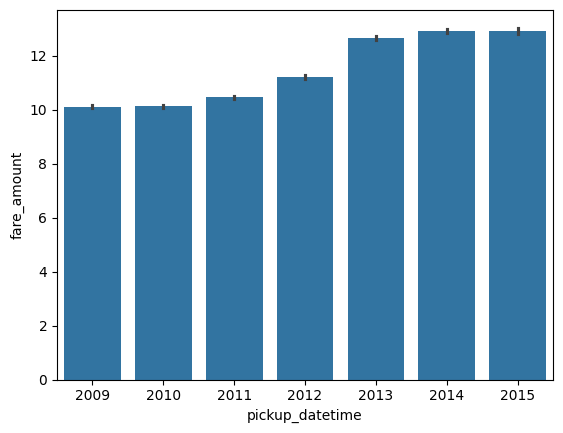

In [9]:
import seaborn as sns
sns.barplot(y = df['fare_amount'], x = df['pickup_datetime'].dt.year)

<Axes: xlabel='passenger_count', ylabel='fare_amount'>

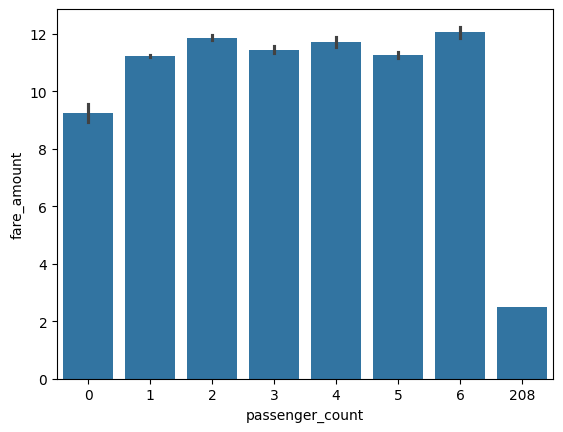

In [10]:
sns.barplot(y = df['fare_amount'], x = df['passenger_count'])

In [11]:
#Remove values that don't make sense
df = df.loc[
    df['fare_amount'].between(0, 200) &
    df['passenger_count'].between(1, 6) &
    df['pickup_latitude'].between(40.5, 41.0) &
    df['dropoff_latitude'].between(40.5, 41.0) &
    df['pickup_longitude'].between(-74.3, -73.6) &
    df['dropoff_longitude'].between(-74.3, -73.6)
]

df = df.loc[df['fare_amount'] > 0]
df = df.loc[~(
    (df['pickup_latitude'] == df['dropoff_latitude']) &
    (df['pickup_longitude'] == df['dropoff_longitude'])
)]

## 3. Prepare Data for Training

In [39]:
#Split the training data to training and validation sets
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)
len(train_df), len(valid_df)

(426140, 106535)

In [40]:
#Fill or Remove Missing Values
train_df = train_df.dropna()
valid_df = valid_df.dropna()

In [41]:
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [42]:
#Extract Inputs and Outputs
input_cols = ['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
target_cols = ['fare_amount']

In [43]:
X_train = train_df[input_cols]
y_train = train_df[target_cols]

X_valid = valid_df[input_cols]
y_valid = valid_df[target_cols]

X_test = test_df[input_cols]

## 4. Train Baseline Model

In [44]:
#Baseline Model: Linear Regression
#from sklearn.linear_model import LinearRegression
#linear_model = LinearRegression()
#linear_model.fit(train_inputs, train_target)

In [45]:
#train_preds = linear_model.predict(train_inputs)
#print(rmse(train_target, train_preds))

## 5. Make Predictions

In [46]:
def predict_and_submit(model, fname):
    test_preds = model.predict(test_inputs)
    sub_df = pd.read_csv('taxi-nyc/sample_submission.csv')
    sub_df['fare_amount'] = test_preds
    sub_df.to_csv(f'taxi-nyc/{fname}', index = None)

## 6. Feature Engineering

In [47]:
#Date feature engineering
def add_date_features(df, col = 'pickup_datetime'):
    df['year'] = df[col].dt.year
    df['month'] = df[col].dt.month
    df['day_of_month'] = df[col].dt.day
    df['day_of_week'] = df[col].dt.weekday
    df['hour'] = df[col].dt.hour
    df['is_weekend'] = df[col].dt.weekday.isin([5,6]).astype('uint8')
    df['is_night'] = ((df[col].dt.hour < 6) | (df[col].dt.hour > 22)).astype('uint8')
    df['rush_hour'] = df[col].dt.hour.isin([7,8,9,16,17,18]).astype('uint8')
    df['week'] = df[col].dt.isocalendar().week.astype('int16')
    df['quarter'] = df[col].dt.quarter
    return df

In [48]:
#Haversine Distance
import numpy as np
def haversine_np(lat1, lon1, lat2, lon2):
    """
    Haversine distance in km
    lat/lon inputs can be scalars, pandas Series, or NumPy arrays
    """
    R = 6371.0  # Earth radius in km
    
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

In [49]:
def add_trip_distance(df):
    df['trip_distance_km'] = haversine_np(
        df['pickup_latitude'],
        df['pickup_longitude'],
        df['dropoff_latitude'],
        df['dropoff_longitude']
    )
    return df

In [50]:
#Is Manhattan or Not
def add_is_manhattan(df):
    df['pickup_in_manhattan'] = (
        (df['pickup_longitude'] > -74.03) &
        (df['pickup_longitude'] < -73.93) &
        (df['pickup_latitude'] > 40.70) &
        (df['pickup_latitude'] < 40.85)
    ).astype('uint8')
    
    df['dropoff_in_manhattan'] = (
        (df['dropoff_longitude'] > -74.03) &
        (df['dropoff_longitude'] < -73.93) &
        (df['dropoff_latitude'] > 40.70) &
        (df['dropoff_latitude'] < 40.85)
    ).astype('uint8')
    
    return df

In [51]:
# Drop Distance from Popular Landmarks
jfk_lonlat = (-73.7781, 40.6413)
lga_lonlat = (-73.8740, 40.7769)
ewr_lonlat = (-74.1745, 40.6895)
met_lonlat = (-73.9632, 40.7794)
wtc_lonlat = (-74.0099, 40.7126)

def add_landmark_dropoff_distance(df, landmark_name, landmark_lonlat):
    lon, lat = landmark_lonlat
    df[landmark_name + '_drop_distance'] = haversine_np(
        df['dropoff_latitude'], df['dropoff_longitude'],
        lat, lon
    )

def add_landmarks(df):
    landmarks = [
        ('jfk', jfk_lonlat),
        ('lga', lga_lonlat),
        ('ewr', ewr_lonlat),
        ('met', met_lonlat),
        ('wtc', wtc_lonlat)
    ]
    for name, lonlat in landmarks:
        add_landmark_dropoff_distance(df, name, lonlat)
    return df

In [52]:
#Going into Manhattan from outside OR out of Manhattan from inside
def cross_manhattan(df):
    df['trip_crosses_manhattan'] = (df['pickup_in_manhattan'] != df['dropoff_in_manhattan']).astype('uint8')
    return df

In [53]:
def add_cross_features(df):
    df["rush_hour_x_distance"] = df["rush_hour"] * df["trip_distance_km"]
    df["cross_manhattan_x_distance"] = df["trip_crosses_manhattan"] * df["trip_distance_km"]
    df["weekend_x_distance"] = df["is_weekend"] * df["trip_distance_km"]
    return df

In [54]:
def add_min_landmark_distance(df):
    landmark_cols = [
        'jfk_drop_distance', 
        'lga_drop_distance', 
        'ewr_drop_distance', 
        'met_drop_distance', 
        'wtc_drop_distance'
    ]
    
    df["min_landmark_distance"] = df[landmark_cols].min(axis = 1)
    
    return df

In [55]:
def add_outlier_flags(df):
    # Flag very short trips
    df["is_short_trip"] = (df["trip_distance_km"] < 1).astype('uint8')
    
    # Flag very long trips
    df["is_long_trip"] = (df["trip_distance_km"] > 30).astype('uint8')

In [56]:
def apply_features(df, datetime_col = "pickup_datetime"):
    add_date_features(df, col = datetime_col)
    add_trip_distance(df)
    add_is_manhattan(df)
    add_landmarks(df)
    cross_manhattan(df)
    add_cross_features(df)
    add_min_landmark_distance(df)
    add_outlier_flags(df)
    return df

In [57]:
X_train = apply_features(X_train)
X_valid = apply_features(X_valid)
X_test = apply_features(X_test)

X_train.shape, X_valid.shape, X_test.shape

((426140, 31), (106535, 31), (9914, 31))

In [58]:
X_train.columns

Index(['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_month', 'day_of_week', 'hour', 'is_weekend',
       'is_night', 'rush_hour', 'week', 'quarter', 'trip_distance_km',
       'pickup_in_manhattan', 'dropoff_in_manhattan', 'jfk_drop_distance',
       'lga_drop_distance', 'ewr_drop_distance', 'met_drop_distance',
       'wtc_drop_distance', 'trip_crosses_manhattan', 'rush_hour_x_distance',
       'cross_manhattan_x_distance', 'weekend_x_distance',
       'min_landmark_distance', 'is_short_trip', 'is_long_trip'],
      dtype='object')

In [59]:
numeric_cols = [
    'year', 'passenger_count',
    'is_weekend', 'is_night', 'rush_hour',
    'trip_distance_km', 'pickup_in_manhattan', 'dropoff_in_manhattan',
    'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
    'met_drop_distance', 'wtc_drop_distance', 'trip_crosses_manhattan',
    'is_short_trip', 'is_long_trip', 'min_landmark_distance', 'rush_hour_x_distance',
    'cross_manhattan_x_distance', 'weekend_x_distance'
]

categorical_cols = ['month', 'quarter', 'day_of_month', 'day_of_week', 'hour', 'week']

target_cols = ['fare_amount']

In [60]:
X_train = X_train[categorical_cols + numeric_cols]
X_valid = X_valid[categorical_cols + numeric_cols]
X_test = X_test[categorical_cols + numeric_cols]

In [61]:
X_train.shape, X_valid.shape, X_test.shape

((426140, 26), (106535, 26), (9914, 26))

## 7. Train and Evaluate LightGBM Model

In [62]:
from sklearn.metrics import mean_squared_error
def rmse(targets, preds):
    return mean_squared_error(targets, preds) ** 0.5

In [63]:
def evaluate(model):
    train_preds = model.predict(X_train)
    train_rmse = rmse(y_train, train_preds)
    valid_preds = model.predict(X_valid)
    valid_rmse = rmse(y_valid, valid_preds)
    return train_rmse, valid_rmse, train_preds, valid_preds

In [69]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 127,
    "feature_fraction": 0.5,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "min_data_in_leaf": 45,
    "lambda_l1": 0.5,
    "lambda_l2": 0.5,
    "verbose": -1,
    'min_gain_to_split': 0.01,
    'max_depth': 10
}

model = LGBMRegressor(**params, n_estimators = 1500, n_jobs = -1, random_state = 123)

model.fit(
    X_train, y_train,
    eval_set = [(X_valid, y_valid)],
    categorical_feature = categorical_cols,
    callbacks = [lgb.early_stopping(150), lgb.log_evaluation(50)]
)

Training until validation scores don't improve for 150 rounds
[50]	valid_0's rmse: 3.75947
[100]	valid_0's rmse: 3.49325
[150]	valid_0's rmse: 3.44155
[200]	valid_0's rmse: 3.41747
[250]	valid_0's rmse: 3.40859
[300]	valid_0's rmse: 3.40305
[350]	valid_0's rmse: 3.40047
[400]	valid_0's rmse: 3.40023
[450]	valid_0's rmse: 3.40021
[500]	valid_0's rmse: 3.40012
[550]	valid_0's rmse: 3.40058
Early stopping, best iteration is:
[420]	valid_0's rmse: 3.39913


,boosting_type,'gbdt'
,num_leaves,127
,max_depth,10
,learning_rate,0.05
,n_estimators,1500
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [73]:
model = LGBMRegressor(**params, n_estimators = 420, n_jobs = -1, random_state = 77)
model.fit(X_train, y_train)
evaluate(model)

(2.9962140489656486,
 3.363582181176794,
 array([ 6.34052088,  7.15096913, 11.73551893, ..., 15.18968977,
        12.89505294, 48.3439625 ], shape=(426140,)),
 array([10.00460479,  5.51965908, 19.05305852, ...,  6.66094735,
        50.37667749,  6.64856233], shape=(106535,)))

In [74]:
results = pd.DataFrame(
    {
        'key': test_df['key'].values,
        'fare_amount': model.predict(X_test)
    }
)
results.to_csv('lgbm_preds.csv', index = None)

In [76]:
importances = model.feature_importances_
feature_names = X_train.columns  

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by = 'importance', ascending = False).reset_index(drop = True)

feature_importance_df

,feature,importance
0,jfk_drop_distance,4384
1,ewr_drop_distance,3857
2,trip_distance_km,3831
3,lga_drop_distance,3802
4,wtc_drop_distance,3611
5,min_landmark_distance,3567
6,met_drop_distance,3469
7,hour,3379
8,cross_manhattan_x_distance,3295
9,week,2700
